In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=07fbf2f93e0bc69019f8c709168a8865f17d8c945466c1a878fd0429743ff526
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from torch import autograd
from torchvision.utils import make_grid
from medmnist import ChestMNIST
from torch.utils.tensorboard import SummaryWriter

In [15]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ChestMNIST(split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = ChestMNIST(split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)


100%|██████████| 82.8M/82.8M [00:08<00:00, 10.3MB/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

class Critic(nn.Module):  
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [18]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    batch_size = min(real_samples.size(0), fake_samples.size(0))
    real_samples, fake_samples = real_samples[:batch_size], fake_samples[:batch_size]
    
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)  # Random weight
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False, device=device)

    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [20]:

latent_dim = 100
lr = 0.0002
epochs = 50
lambda_gp = 10  
critic_iters = 5 

In [21]:
generator = Generator(latent_dim).to(device)
critic = Critic().to(device)

In [22]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.999))

writer = SummaryWriter("runs/wgan_gp_experiment")


In [25]:
print("Starting WGAN-GP Training...")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)

        # Train Critic multiple times
        for _ in range(critic_iters):
            optimizer_D.zero_grad()

            # Generate fake images
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            fake_images = generator(z)

            real_loss = critic(real_images).mean()
            fake_loss = critic(fake_images.detach()).mean()

            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images)
            d_loss = -real_loss + fake_loss + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        fake_loss_G = -critic(fake_images).mean()
        fake_loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {fake_loss_G.item():.4f}")


Starting WGAN-GP Training...
Epoch [1/50] | D Loss: -2.8497 | G Loss: -1.6514
Epoch [2/50] | D Loss: -3.0978 | G Loss: 1.8912
Epoch [3/50] | D Loss: -7.0940 | G Loss: 0.8261
Epoch [4/50] | D Loss: -3.3509 | G Loss: 2.2680
Epoch [5/50] | D Loss: -3.2588 | G Loss: 1.8522
Epoch [6/50] | D Loss: -6.1135 | G Loss: -3.9719
Epoch [7/50] | D Loss: -2.2807 | G Loss: 2.5832
Epoch [8/50] | D Loss: -6.0682 | G Loss: -1.7646
Epoch [9/50] | D Loss: -4.7623 | G Loss: 5.2973
Epoch [10/50] | D Loss: -1.4580 | G Loss: -1.3200
Epoch [11/50] | D Loss: -2.6224 | G Loss: 0.1026
Epoch [12/50] | D Loss: -3.3923 | G Loss: 0.0980
Epoch [13/50] | D Loss: -5.9505 | G Loss: -3.8825
Epoch [14/50] | D Loss: -4.0948 | G Loss: -0.3925
Epoch [15/50] | D Loss: -2.0340 | G Loss: -1.4049
Epoch [16/50] | D Loss: -3.0392 | G Loss: 8.4809
Epoch [17/50] | D Loss: -3.5655 | G Loss: 4.4669
Epoch [18/50] | D Loss: -2.4584 | G Loss: -3.5110
Epoch [19/50] | D Loss: -1.1843 | G Loss: -5.6937
Epoch [20/50] | D Loss: -1.8432 | G Loss

In [26]:
os.makedirs("saved_models", exist_ok=True)
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(critic.state_dict(), "saved_models/critic.pth")
print("Models saved successfully!")

Models saved successfully!


In [27]:
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn.functional as F

inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1).to(device)
inception_model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 221MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [30]:
def get_pred(x):
    with torch.no_grad():
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()

def inception_score(images, batch_size=32, splits=10):
    preds = np.zeros((len(images), 1000))
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        preds[i:i + batch_size] = get_pred(batch)

    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = np.mean(k, axis=0)
        kl_div = k * (np.log(k) - np.log(p_yx))
        split_scores.append(np.sum(kl_div, axis=1).mean())

    return np.exp(np.mean(split_scores))

def calculate_fid(real_images, fake_images):
    real_images = real_images.view(real_images.size(0), -1).cpu().numpy()
    fake_images = fake_images.view(fake_images.size(0), -1).cpu().numpy()

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    fid_matrix = sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake)
    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(fid_matrix)

    return np.real(fid_score)

In [29]:
# Load test images and compute scores
real_images, _ = next(iter(test_loader))
real_images = real_images.to(device)

num_samples = 1000
z = torch.randn(num_samples, latent_dim).to(device)
fake_images = generator(z).detach().to(device)

is_score_real = inception_score(real_images)
fid_score = calculate_fid(real_images, fake_images)

print(f"Inception Score: {is_score_real:.4f}")
print(f"FID Score: {fid_score:.4f}")

Inception Score: 1.9554
FID Score: 4.5178


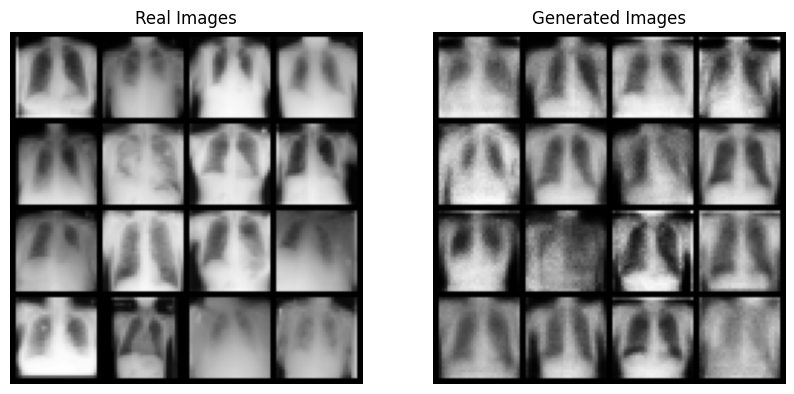

In [31]:
import torchvision.utils as vutils

# Function to show images
def show_images(real, fake, num_images=16):
    real = real[:num_images].cpu()
    fake = fake[:num_images].cpu()

    grid_real = vutils.make_grid(real, nrow=4, normalize=True)
    grid_fake = vutils.make_grid(fake, nrow=4, normalize=True)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(grid_real.permute(1, 2, 0))
    axes[0].set_title("Real Images")
    axes[0].axis("off")

    axes[1].imshow(grid_fake.permute(1, 2, 0))
    axes[1].set_title("Generated Images")
    axes[1].axis("off")

    plt.show()

# Show real vs generated images
show_images(real_images, fake_images)
